# Inception V4 Bone Age Prediction

## Library installation and modules imports
We uploaded on PyPi our own library containing the functions needed to define the models and preprocess the images, the ratio for this is to allow for a leaner structure and better redability of the notebook

In [ ]:
!pip install Human_Data_Analytics

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import random
import pandas as pd
import gc

#our library uploaded with pypi as a python package
from HDA.preprocessing.image_pre_processing import data_generator_patch, plot_processed_image
from HDA.models.Inception import Inceptionv4

from tensorflow.keras.optimizers import Adam

#Setting the seed
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

## Model and splits definition
Here we define the model, the used hyperparameters and the splits to be use in our pipeline

In [ ]:
lr = 0.0001
batch_size = 40
train_samples = 16e3
num_patches_per_side = 5
crop_list = {'top': 0.1, 'bottom': 0.05, 'left': 0.1, 'right': 0.1}
augmentations = [0,1,3,4] # 0: flip, 1: rotation, 2: zoom, 3:blur, 4:identity
prob = [1/len(augmentations)]*len(augmentations) #probability for each possible data augmentation type
total_num_patches = num_patches_per_side ** 2

In [ ]:
# Input image shape (example: 224x224 RGB image)
input_shape = (224, 224, 3)
gender_input_shape = (1,)  # Assuming a scalar for gender input

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    optimizer = Adam(learning_rate=lr)
    model = Inceptionv4(input_shape, gender_input_shape)
    model.compile(optimizer=optimizer, loss='mae')

# Display model architecture
model.summary()

Number of devices: 2


Model: "Inceptionv4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_stem_1th       │ (None, 111, 111,  │        896 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_stem_1th         │ (None, 111, 111,  │        128 │ conv_stem_1th[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ bn_stem_1th[0][0] │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_stem_2nd       │ (None, 109, 109,  │      9,248 │ activation[0][0]  │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_stem_2nd         │ (None, 109, 109,  │        128 │ conv_stem_2nd[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ bn_stem_2nd[0][0] │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_stem_3rd       │ (None, 109, 109,  │     18,496 │ activation_1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_stem_3rd         │ (None, 109, 109,  │        256 │ conv_stem_3rd[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ bn_stem_3rd[0][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_stem_1stbranc… │ (None, 54, 54,    │     55,392 │ activation_2[0][… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_stem_1stbranch_2 │ (None, 54, 54,    │        384 │ conv_stem_1stbra… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_1stbranch_1    │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ bn_stem_1stbranc… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 54, 54,    │          0 │ stem_1stbranch_1… │
│ (Concatenate)       │ 160)              │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_stem_2ndbranc… │ (None, 54, 54,    │     10,304 │ concatenate[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_stem_2ndbranch_… │ (None, 54, 54,    │        256 │ conv_stem_2ndbra

 Total params: 41,239,153 (157.31 MB)

 Trainable params: 41,175,985 (157.07 MB)

 Non-trainable params: 63,168 (246.75 KB)

In [ ]:
train_path = "/kaggle/input/dataset-boneage/train"
val_path = "/kaggle/input/dataset-boneage/val"
load_path = '/kaggle/input/boneageprediction/tensorflow2/default/32/Inceptionv4_first_epochs.h5'
save_path_first_part = os.path.join("/kaggle/working/", "Inceptionv4_first_epochs.h5")
save_path_second_part = os.path.join("/kaggle/working/", "Inceptionv4.h5")

In [ ]:
extracted_files = os.listdir(os.path.join(train_path, 'images'))
num_train_images=len(extracted_files)
print("Number of training images:", num_train_images)
del extracted_files
gc.collect()

Number of training images: 12611


14

In [ ]:
# Create a Dataset from the generator
labels_training = pd.read_csv(os.path.join(train_path, 'labels.csv'))
labels_training_age = labels_training['Bone Age (months)'].astype(np.float32).to_list()
gender_training = labels_training['male'].apply(lambda x: 1 if x == True else 0).astype(np.float32).to_list() # True if male and False if female

preprocessed_images_train = tf.data.Dataset.from_generator(
    lambda: data_generator_patch(os.path.join(train_path, 'images'),
                           gender_training, labels_training_age,
                            admissible_augmentations=[0,1,3,4], prob = [1/4]*4, 
                            num_patches_per_side = num_patches_per_side, data_size = train_samples, crop_list=crop_list),
    output_signature=(
        (tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name="image"),  # Input shape
        tf.TensorSpec(shape=(), dtype=tf.float32, name="gender")),   # Gender shape
        tf.TensorSpec(shape=(), dtype=tf.float32, name="label")   # Target shape
    )
)

preprocessed_images_train = preprocessed_images_train.repeat()
preprocessed_images_train = preprocessed_images_train.batch(batch_size)
training_dataset = preprocessed_images_train.prefetch(tf.data.AUTOTUNE)

print('batch_size:', batch_size)

batch_size: 40


In [ ]:
extracted_files = os.listdir(os.path.join(val_path, 'images'))
num_val_images=len(extracted_files)
print("Number of validation images:", num_val_images)
del extracted_files
gc.collect()

Number of validation images: 1425


0

In [ ]:
labels_val = pd.read_csv(os.path.join(val_path, 'labels.csv'))
labels_val_age = labels_val['Bone Age (months)'].astype(np.float32).to_list()
gender_val = labels_val['male'].apply(lambda x: 1 if x == True else 0).astype(np.float32).to_list()

preprocessed_images_val = tf.data.Dataset.from_generator(
    lambda: data_generator_patch(os.path.join(val_path, "images"),
                                 gender_val, 
                                 labels_val_age, 
                                 train = False,
                                 num_patches_per_side = num_patches_per_side, 
                                 crop_list=crop_list),
    output_signature=(
        (tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name="image"),  #Input shape
        tf.TensorSpec(shape=(), dtype=tf.float32, name="gender")),   #Gender shape
        tf.TensorSpec(shape=(), dtype=tf.float32, name="label")   #Target shape
    )
)

preprocessed_images_val = preprocessed_images_val.repeat()
preprocessed_images_val = preprocessed_images_val.batch(total_num_patches)
val_dataset = preprocessed_images_val.prefetch(tf.data.AUTOTUNE)

### Preprocess and Augmentations
Here we show an example of the results of our preprocessing pipeline. The images are first resized, cropped and CLAHE is applied, they are then splitted in 25 overlapping patch, 5 by each side of the image.
\
The patches are then augment with random flip(vetical or horizontal), rotation(|angle| <= 30), gaussian blur(sigma between 0.4 and 2.5) or identity

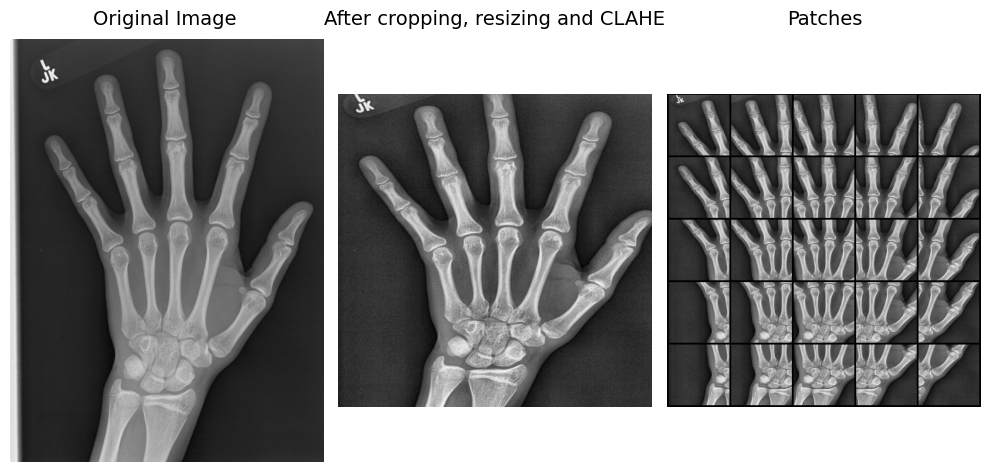

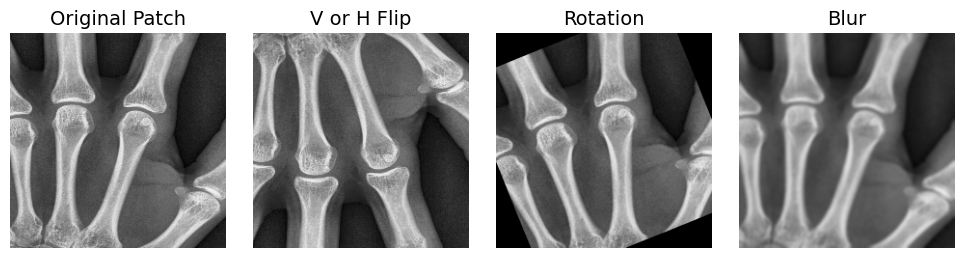

In [ ]:
plot_processed_image(os.path.join(train_path, 'images'), num_patches_per_side = num_patches_per_side)

## Training
Due to the limitations of the platform used, the training was performed in two different runs, saving the model after the first part of training and load it again for the second part of it.
\
For the sake of readability, the two trainings are here inserted sequentially, but they were actually performed in two different notebook, using the same hyperparameters for both runs.
\
This notebook remains however fully working and can be run like it is.

In [ ]:
train_steps = int(np.ceil(train_samples/(batch_size)))
val_steps = int(np.ceil(len(labels_val_age)))

In [ ]:
#First part of training
history = model.fit(
    training_dataset,
    validation_data=val_dataset,
    epochs=35,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    batch_size=batch_size
)

Epoch 1/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 1353s 2s/step - loss: 116.6037 - val_loss: 95.5400
Epoch 2/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 890s 2s/step - loss: 86.9202 - val_loss: 68.1475
Epoch 3/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 872s 2s/step - loss: 59.1289 - val_loss: 116.1178
Epoch 4/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 868s 2s/step - loss: 40.5995 - val_loss: 35.7702
Epoch 5/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 866s 2s/step - loss: 33.8099 - val_loss: 35.0287
Epoch 6/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 865s 2s/step - loss: 31.7584 - val_loss: 27.1025
Epoch 7/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 867s 2s/step - loss: 29.9352 - val_loss: 26.1046
Epoch 8/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 864s 2s/step - loss: 28.9119 - val_loss: 23.5732
Epoch 9/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 861s 2s/step - loss: 27.6040 - val_loss: 21.6990
Epoch 10/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 863s 2s/step - loss: 27.3261 - val_loss: 21.4435
Epoch 11/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 864s 2s/step - loss: 26.2658 - val_loss: 20.3059
Epoch 12/35
400/

In [ ]:
#We save the model
model.save(save_path_first_part)

In [ ]:
#Load the model and compile it again
with strategy.scope():
    model_2nd = load_model(load_path, 
                   compile=False)
    optimizer = Adam(learning_rate=lr)
    model_2nd.compile(optimizer=optimizer, loss='mae')

In [ ]:
#callback for early stopping
callback_1 = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           patience=15, 
                           restore_best_weights=True)

#Second part of training
history = model_2nd.fit(
    training_dataset,
    validation_data=val_dataset,
    epochs=40,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    batch_size=batch_size,
    callbacks=[callback_1]
)

Epoch 1/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1307s 2s/step - loss: 14.4479 - val_loss: 14.6128
Epoch 2/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 888s 2s/step - loss: 13.5915 - val_loss: 12.3730
Epoch 3/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 876s 2s/step - loss: 13.5783 - val_loss: 12.9690
Epoch 4/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 868s 2s/step - loss: 13.5745 - val_loss: 12.0602
Epoch 5/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 871s 2s/step - loss: 13.4156 - val_loss: 18.2616
Epoch 6/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 873s 2s/step - loss: 13.3203 - val_loss: 11.7350
Epoch 7/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 875s 2s/step - loss: 12.8120 - val_loss: 11.6346
Epoch 8/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 872s 2s/step - loss: 12.9718 - val_loss: 13.6197
Epoch 9/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 868s 2s/step - loss: 12.7280 - val_loss: 14.4738
Epoch 10/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 869s 2s/step - loss: 12.9564 - val_loss: 15.0115
Epoch 11/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 865s 2s/step - loss: 12.6914 - val_loss: 11.4763
Epoch 12/40
400/40

In [ ]:
#We save the full trained model
model_2nd.save(save_path_second_part)